In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
from sklearn import preprocessing
from numpy.random import seed
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras import backend
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from keras import regularizers
import time
import math

In [43]:
def PlotScatter(var,t):
    data = pd.concat((train_df[TargetIndex[t]], train_df[var]),axis=1)  
    f, ax = plt.subplots(figsize=(16, 8))
    fig = plt.scatter(x=var, y=TargetIndex[t], data=data)
def PlotBox(var,t):
    data = pd.concat((train_df[TargetIndex[t]], train_df[var]),axis=1)  
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y=TargetIndex[t], data=data)
    fig.axis(ymin=0, ymax=5)
def History(hist):
    plt.plot(hist.history["mae"])
    plt.plot(hist.history["val_mae"])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

In [27]:
Label_Index = ['PLC_THICKNESS_SP','PLC_THICKNESS_PV','THICKNESS_1','PLC_THICKNESS_1','XXXX_RATE_2','PREHEAT_XTAL_USE_TIME_2','CELL_CHANGE_CTRL_DLY_TIME_2','XXXX_USE_TIME_2','PLC_THICKNESS_2','RAW_RATE_3','THICKNESS_3','STATE_3','XXXX_RATE_3','XXXX_POWER_3','MASK_CHANGE_COUNT_PV']
Columns = ["id","5-1_value","5-2_value","5-3_value","2-1_M","2-3_M","3-1_M","5-1_M","5-3_M","TYPE"]
TargetIndex = ["CIEX","CIEY","CIEX_DIFF","CIEY_DIFF"]
num ="5"
Dp = ['id','5-1_value','5-2_value','5-3_value']
FeatureIndex = [num+"-1_M",num+"-1_cell",num+"-1_value",num+"-2_M",num+"-2_cell",num+"-2_value",num+"-3_M",num+"-3_cell",num+"-3_value"]

In [4]:
train_df = pd.read_csv("data1/train.csv")
train_log_df = pd.read_csv("data1/train_log.csv")
test_df = pd.read_csv("data1/test.csv")
test_log_df = pd.read_csv("data1/test_log.csv")
all_df = pd.concat([train_df,test_df])
all_log_df = pd.concat([train_log_df,test_log_df])
Data_df = all_df[Columns]
OneHotData_df = pd.get_dummies(Data_df)
OneHotData_df = OneHotData_df.interpolate()

C:\Users\USER\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
Log_df = pd.DataFrame(all_log_df[all_log_df['P_ID']==all_df['P_ID'].iloc[0]].sort_values(['NUMBER_OF_PROCESSING']).mean())
for i in range(1,len(all_df['P_ID']),1):
    Log_df.insert(Log_df.shape[1],i,all_log_df[all_log_df['P_ID']==all_df['P_ID'].iloc[i]].sort_values(['NUMBER_OF_PROCESSING']).mean())
Log_df = Log_df.T

In [28]:
Std = ["5-1_value","5-2_value","5-3_value"]
OneHotData_df[Std] = preprocessing.scale(OneHotData_df[Std])
Log_label = pd.DataFrame(preprocessing.scale(Log_df[Label_Index]))

In [44]:
train_log = Log_label[:4963]
sub_log = Log_label[4963:]
train_label_log = Log_label[:3000]
test_label_log = Log_label[3000:4963]
sub_label_log = sub_log
train = OneHotData_df[:4963]
sub = OneHotData_df[4963:]
train_label = train[:3000]
train_feature = all_df[TargetIndex][:3000]
test_label = train[3000:4963]
test_feature = all_df[TargetIndex][3000:4963]
sub_label = sub

for i in range(train_label_log.shape[1]):
    train_label.insert(train_label.shape[1],Label_Index[i],train_label_log[i])
for i in range(test_label_log.shape[1]):
    test_label.insert(test_label.shape[1],Label_Index[i],test_label_log[i])
for i in range(sub_label_log.shape[1]):
    sub_label.insert(sub_label.shape[1],Label_Index[i],sub_label_log[i])

In [58]:
train_feature[TargetIndex[:2]]

,CIEX,CIEY
0,3.138889,2.161998
1,3.139217,2.162539
2,3.139260,2.161272
3,3.133462,2.159586
4,3.134885,2.160474
...,...,...
2995,3.136716,2.159937
2996,3.139992,2.162748
2997,3.139427,2.162714
2998,3.140378,2.163554


In [71]:
backend.clear_session()
seed(3)
#main neul network
model = Sequential()
#set layer
model.add(Dense(100, kernel_initializer="uniform", input_dim=50,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=18,activation='relu' ))
model.add(Dense(units=18,activation='relu' ))
model.add(Dense(units=18,activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(units=2,activation='relu'))
#model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
# my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
hist = model.fit(train_label.drop(['id'],axis=1), train_feature[TargetIndex[:2]], batch_size=96,epochs=10000 , verbose=0,validation_split=0.2,callbacks=[callback])

In [74]:
backend.clear_session()
seed(3)
#main neul network
model2 = Sequential()
#set layer
model2.add(Dense(100, kernel_initializer="uniform", input_dim=32,activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dense(units=18,activation='relu' ))
model2.add(Dropout(0.2))
model2.add(Dense(units=2,activation='relu'))
#model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
# my_sgd = optimizers.SGD(lr=0.032, decay=1e-6, momentum=0.7, nesterov=True)
model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
hist = model2.fit(train_label.drop(Dp+Label_Index,axis=1), train_2_feature[TargetIndex[2:]], batch_size=96, epochs=10000, verbose=0,validation_split=0.2,callbacks=[callback])

In [76]:
model.predict(train_label.drop(['id'],axis=1))

array([[3.1152692, 2.1613536],
       [3.1148467, 2.1613564],
       [3.1136212, 2.1613648],
       ...,
       [3.111336 , 2.16138  ],
       [3.1118202, 2.1613781],
       [3.1103122, 2.1613898]], dtype=float32)

In [77]:
test_1_Pre =  model.predict(test_label.drop(['id'],axis=1))
test_1_Pre = pd.DataFrame(test_1_Pre,index = range(3000,4963,1))

Predict2 = model2.predict(test_label.drop(Dp+Label_Index,axis=1))
Predict2 = pd.DataFrame(Predict2,index = range(3000,4963,1))
Pre_df1 = pd.DataFrame(test_1_Pre)
Pre_df1.insert(2,'3',Predict2[1])
Pre_df1.insert(2,'2',Predict2[0])

ndarray = Pre_df1.values
Pre_df = pd.DataFrame(ndarray)

In [78]:
test_feature

,CIEX,CIEY,CIEX_DIFF,CIEY_DIFF
3000,3.138671,2.160913,0.00885,0.00300
3001,3.138246,2.160280,0.00920,0.00585
3002,3.135933,2.158604,0.00620,0.00380
3003,3.140776,2.166434,0.00425,0.00235
3004,3.138951,2.164124,0.00630,0.00330
...,...,...,...,...
4958,0.733000,4.750889,0.00320,0.00265
4959,0.732655,4.751256,0.00270,0.00275
4960,0.732672,4.751435,0.00285,0.00265
4961,0.732709,4.751304,0.00295,0.00255


In [79]:
Pre_df

,0,1,2,3
0,3.113810,2.161362,0.006631,0.007424
1,3.108523,2.161398,0.006631,0.007424
2,3.110381,2.161388,0.006631,0.007424
3,3.111141,2.161381,0.006631,0.007424
4,3.110942,2.161383,0.006631,0.007424
...,...,...,...,...
1958,0.822330,4.631449,0.003939,0.003739
1959,0.815190,4.641328,0.003939,0.003739
1960,0.822120,4.631734,0.003939,0.003739
1961,0.821962,4.631952,0.003939,0.003739


In [80]:
test_feature = all_df[TargetIndex][3000:4963]
W = [0.249,0.330,0.172,0.204]
Wmae = 0
for n in range(4):
    MAE = 0
    for i in range(len(Pre_df[0])):
        MAE = MAE + abs(Pre_df[n][i]-test_feature[TargetIndex[n]].iloc[i])
    Wmae = Wmae + (MAE/len(Pre_df[n]))*W[n]
print(Wmae/4)

0.024848183695012016


In [285]:
sub_1_Pre =  model.predict(sub_label.drop(['id'],axis=1))
sub_1_Pre = pd.DataFrame(sub_1_Pre)
sub_2_label = sub_label.drop(['id','5-1_value','5-2_value','5-3_value'],axis=1)
sub_2_label.insert(0,'CIEY',sub_1_Pre[1])
sub_2_label.insert(0,'CIEX',sub_1_Pre[0])

Predict2 = model2.predict(sub_2_label)
Predict2 = pd.DataFrame(Predict2)
Pre_df1 = pd.DataFrame(sub_1_Pre)
Pre_df1.insert(2,'3',Predict2[1])
Pre_df1.insert(2,'2',Predict2[0])

ndarray = Pre_df1.values
Pre_df = pd.DataFrame(ndarray)

In [288]:
writer = pd.ExcelWriter('subfinal.xlsx')
Pre_df.to_excel(writer,sheet_name="1")
writer.save()

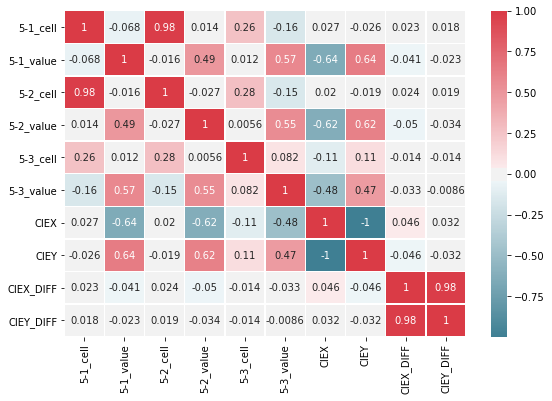

In [7]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = plt.subplots(figsize=(9, 6))
sns.heatmap(train_df[FeatureIndex+TargetIndex].corr(),annot=True,cmap = cmap , linewidths=.5)
plt.savefig("HtMap.jpg")